In [ ]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Risoe

In [ ]:
file_path_risoe = 'Data/Risoe/risoe_m_all.nc'

dataset = nc.Dataset(file_path_risoe, 'r')

Load mast data in a dataframe

In [ ]:
# as we have found out the qc values are either 0 or nan. So we guess it means quality control
# and we think we can remove those

# lets convert data to dataframe
column_names = []
for var_name in dataset.variables:
    column_names.append(var_name)
    
df_data = pd.DataFrame()
for column_name in column_names:
    tmp_np = np.array(dataset.variables[column_name])
    df_data[column_name] = tmp_np
df_data.describe()

In [ ]:
df_data = df_data.dropna()
df_data.describe()

In [ ]:
df_data.columns.values

#remove qc columns
df_cols_to_drop = []
for col in df_data.columns.values:
    if col.endswith("_qc"):
        df_cols_to_drop.append(col)
        
df_mast = df_data.drop(df_cols_to_drop, axis=1)

In [ ]:
#histogram for all mast columns
df_mast.hist()
print("")

In [ ]:
plt.imshow(df_mast.corr())
# display only columns with correlation higher than 0.75
my_corr = df_mast.corr()
my_corr[my_corr > 0.75].dropna(thresh=2).dropna(thresh=2, axis=1)

In [ ]:
# convert time from mast to timestamp
base_date_borglum = datetime(1997, 12, 11, 16, 5, 0)
base_date_risoe = datetime(1995, 11, 20, 16, 25, 0)

def time_convert(input):
    time_delta = timedelta(minutes=int(input))
    timestamp = base_date_risoe + time_delta
    return pd.to_datetime(timestamp)
    # return timestamp.strftime('%Y-%m-%d %H:%M:%S')


for index, row in df_mast.iterrows():
    time = row['time']
    time_stamp = time_convert(time)
    df_mast.at[index, 'TIMESTAMP'] = time_stamp

df_mast['TIMESTAMP'] = pd.to_datetime(df_mast['TIMESTAMP'])

we chose to use ws and wd for height 125 in mast so all the other columns that are no longer relevant are dropped

In [ ]:
df_mast_just_wind = df_mast.drop(['time','ws44','ws77','wd77','t003','t044','t118','td01','rain','press','rhum','grad'], axis=1)
df_mast_just_wind.head()

created a new season column based on the timestamp

In [ ]:
df_mast_wind_month = df_mast_just_wind.copy()

df_mast_wind_month.dtypes

print(((df_mast['TIMESTAMP'].dt.month + 1) // 4) + 1)
df_mast_wind_month['season'] = ((df_mast['TIMESTAMP'].dt.month + 1) // 4) + 1
df_mast_wind_month['year'] = df_mast['TIMESTAMP'].dt.year

df_mast_wind_month.head(10)

In [ ]:
#set the wind direction to 0 if 360 to avoid the avg becoming 180; also 0 and 360 are kind of the same thing
df_mast_wind_month.loc[df_mast_wind_month['wd125'] == 360, 'wd125'] = 0

df_mast_wind_month.describe()

In [ ]:
#create columns for east and north based on cartesian coordinates for the wind speed and wind direction
df_mast_wind_month_cartesian = df_mast_wind_month.copy()

df_mast_wind_month_cartesian['east'] = df_mast_wind_month_cartesian['ws125'] * np.sin((df_mast_wind_month_cartesian['wd125']/360) * 2*np.pi)
df_mast_wind_month_cartesian['north'] = df_mast_wind_month_cartesian['ws125'] * np.cos((df_mast_wind_month_cartesian['wd125']/360) * 2*np.pi)

df_mast_wind_month_cartesian.head(10)

This is a wind turbine that moves towards the wind direction\
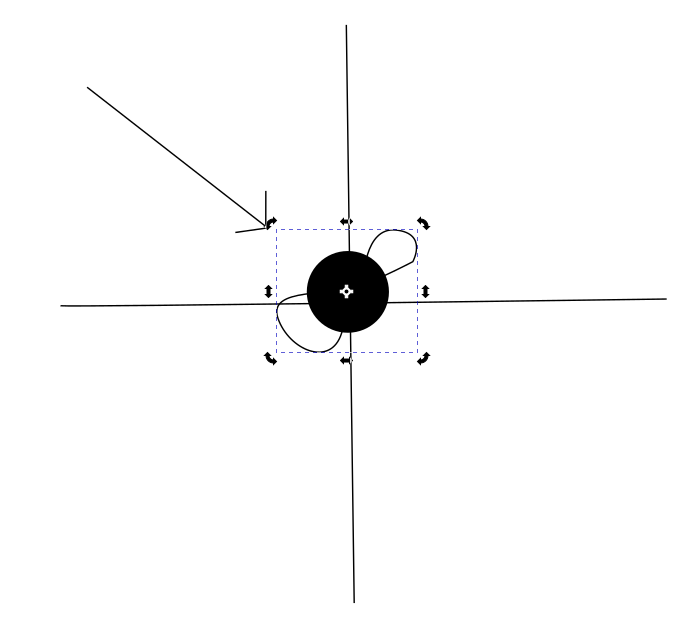

In [ ]:
df_mast_wind_month_cartesian['TIMESTAMP'].duplicated().drop_duplicates()
# there are no two times same so we expect that there was no time shift so no need to convert the timestamp to DK time

# Meso part

In [ ]:
df_meso = pd.read_csv('Data/Risoe/meso_Risoe.csv')

In [ ]:
#convert the datetime
df_meso['TIMESTAMP'] = pd.to_datetime(df_meso['TIMESTAMP'])
df_meso.head(10)
df_meso.dtypes

In [ ]:
# find if there are duplicates in date
df_meso['TIMESTAMP'].duplicated().drop_duplicates()


In [ ]:
#similar to mast, keep only data relevant to the height chosen

df_meso_cleaned = df_meso[['TIMESTAMP','WSP120','WDIR120']]
df_meso_cleaned

In [ ]:
#split the timestamp into separate columns and also grouping the mast data into groups of 1 hour
# taking the avg north and east speed for mast and combining them into polar coordinates

df_mast_wind_month_cartesian['year'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.year
df_mast_wind_month_cartesian['month'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.month
df_mast_wind_month_cartesian['day'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.day
df_mast_wind_month_cartesian['hour'] = df_mast_wind_month_cartesian['TIMESTAMP'].dt.hour
mast_hourly_average = df_mast_wind_month_cartesian.groupby(['year', 'month', 'day', 'hour'])['north'].mean().reset_index()
hourly_average_east = df_mast_wind_month_cartesian.groupby(['year', 'month', 'day', 'hour'])['east'].mean().reset_index()

mast_hourly_average['east'] = hourly_average_east['east']
mast_hourly_average['ws125'] = np.sqrt(mast_hourly_average['east']**2 + mast_hourly_average['north']**2)
mast_hourly_average['wd125'] = (np.arctan2(mast_hourly_average['east'], mast_hourly_average['north'])/(2*np.pi)) * 360
mast_hourly_average.head(10)

In [ ]:
# convert into datetime 

def time_convert(year,month,day,hour):
    timestamp = datetime(int(year),int(month),int(day),int(hour),0,0)
    return pd.to_datetime(timestamp)
    
for index, row in mast_hourly_average.iterrows():
    time_stamp = time_convert(row['year'],row['month'],row['day'],row['hour'])
    mast_hourly_average.at[index, 'TIMESTAMP'] = time_stamp


In [ ]:
# dropped timestamp subsets and added season
mast_hourly_average_calculated = mast_hourly_average.drop(['month','day','hour'], axis=1)

mast_hourly_average_calculated['season'] = ((mast_hourly_average_calculated['TIMESTAMP'].dt.month + 1) // 4) + 1

mast_hourly_average_calculated

In [ ]:
#join mast and meso data based on timestamp
df_result = mast_hourly_average_calculated.join(df_meso_cleaned.set_index('TIMESTAMP'), on='TIMESTAMP', validate='1:1', rsuffix= 'x', lsuffix='y')
df_result_cleaned = df_result.dropna()
df_result_cleaned.describe()
df_result_cleaned.tail(20)

In [ ]:
# cleaning the data, assuming that ws125=0.15 and wd125=0 is an error, remove all records with these value combinations
resultv1 = (df_result_cleaned.loc[(df_result_cleaned['ws125'] != 0.15) | (df_result_cleaned['wd125'] != 0)])

resultv1.hist()
print('')

In [ ]:
# as a result of plotting the data, certain outliers will be removed

data_without_outliers = resultv1.copy()

data_without_outliers = data_without_outliers.loc[(data_without_outliers['ws125'] > 0.2)]
data_without_outliers

In [ ]:
# check if ws follows weibull for mast windspeed

c, loc, scale = weibull_min.fit(data_without_outliers['ws125'].values)

fig, ax = plt.subplots(1, 1)
x = np.linspace(weibull_min.ppf(0.005, c,loc= loc, scale = scale),
                weibull_min.ppf(0.995, c, loc= loc, scale = scale), 100)
ax.plot(x, weibull_min.pdf(x, c, loc= loc, scale = scale),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')

ax.hist(data_without_outliers['ws125'].values, density=True, bins='auto', histtype='stepfilled', alpha=0.2)

ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)

plt.show()

In [ ]:
# check if ws follows weibull for meso windspeed

c, loc, scale = weibull_min.fit(data_without_outliers['WSP120'].values)
fig, ax = plt.subplots(1, 1)
x = np.linspace(weibull_min.ppf(0.005, c, loc= loc, scale = scale),
                weibull_min.ppf(0.995, c, loc=loc, scale = scale), 100)
ax.plot(x, weibull_min.pdf(x, c, loc= loc, scale = scale),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')

ax.hist(data_without_outliers['WSP120'].values, density=True, bins='auto', histtype='stepfilled', alpha=0.2)

ax.set_xlim([x[0], x[-1]])

ax.legend(loc='best', frameon=False)

plt.show()

In [ ]:
#drop the timestamp and checking the correlation of the data
data_without_outliers.corr()

data_without_outliersv2 = data_without_outliers.drop(['TIMESTAMP'], axis = 1)

my_corr = data_without_outliersv2.corr()
display(my_corr[(my_corr > 0.75) | (my_corr < -0.75)].dropna(thresh=2).dropna(thresh=2, axis=1))
display(my_corr)

data_without_outliersv2.corr()

## Model development